In [8]:
from diffusers import StableDiffusionPipeline

import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import pandas as pd

import googletrans

import matplotlib.pyplot as plt
import numpy as np

In [9]:
pipe = StableDiffusionPipeline.from_pretrained(
	"runwayml/stable-diffusion-v1-5", 
	use_auth_token=True
).to("cuda")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [10]:
# example of image path : /home/datasets/ImageNet1K/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_8240.JPEG 

# ImageCaptionPair Dataset
class ICP_Dataset(Dataset):
    def __init__(self, root_folder: Path, save_image_folder_name: Path):
        self.csv_list = list(root_folder.joinpath('train_csv').glob("*.csv"))
        self.save_image_path = root_folder.joinpath(save_image_folder_name)
        self.save_image_path.mkdir(parents=True, exist_ok=True)

        self.data = pd.concat([pd.read_csv(csv_file, sep=r",(?:(?!\s)+(?!')+(?!$))", engine='python') for csv_file in self.csv_list])
        self.image_path = self.data["org_img_path"].tolist()
        self.caption = self.data["caption"].tolist()

        if len(self.image_path) != len(self.caption):
            raise ValueError("image_path and caption must have the same length")

        # self.image_class = list(map(lambda x: x.split("/")[-2], self.image_path))
        # self.image_name = list(map(lambda x: x.split("/")[-1].split(".")[0], self.image_path))

    def __getitem__(self, idx):
        prompt = self.caption[idx]
        generator_seed = idx
        num_inference_steps = 20

        image_path = Path(self.image_path[idx])
        image_cls = image_path.parts[-2]
        image_name = image_path.stem

        return {"prompt": prompt, "generator_seed": generator_seed, "num_inference_steps": num_inference_steps}, self.save_image_path.joinpath(image_cls).joinpath(image_name + ".png")

    def __len__(self):
        return len(self.data)


# Back Translated Image Dataset
class BTI_Dataset(ICP_Dataset):
    def __init__(self, root_folder: Path, save_image_folder_name: Path = Path("BackTrans"), src_lang: str = 'en', tgt_lang: str = 'ko'):
        super().__init__(root_folder, save_image_folder_name)
        self.translator = googletrans.Translator()
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
    
    def __getitem__(self, idx):
        prompt = self.caption[idx]
        trans_prompt = self.translator.translate(prompt, dest=self.tgt_lang).text
        back_trans_prompt = self.translator.translate(trans_prompt, dest=self.src_lang).text
        generator_seed = idx
        num_inference_steps = 20

        image_path = Path(self.image_path[idx])
        image_cls = image_path.parts[-2]
        image_name = image_path.stem

        return {"prompt": back_trans_prompt, "generator_seed": generator_seed, "num_inference_steps": num_inference_steps}, self.save_image_path.joinpath(image_cls).joinpath(image_name + ".png")

In [11]:
root_folder = Path("/home/tak/IBT/Image-back-translation/data/ImageNet1K/ILSVRC/Data/CLS-LOC")
dataset = BTI_Dataset(root_folder)

In [12]:
def collate_fn(batch):
    # 데이터 및 메타데이터 리스트 분리
    data_list, meta_list = zip(*batch)

    # 데이터 배치 생성
    data_batch = {
        'prompt': [item['prompt'] for item in data_list],
        'generator_seed': torch.tensor([item['generator_seed'] for item in data_list]),
        'num_inference_steps': torch.tensor([item['num_inference_steps'] for item in data_list]),
    }

    # 메타데이터는 리스트로 유지
    meta_batch = list(meta_list)

    return data_batch, meta_batch

In [13]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [14]:
for batch_idx, (data_batch, path_batch) in enumerate(dataloader):
    generator = [torch.Generator(device="cuda").manual_seed(seed.item()) for seed in data_batch["generator_seed"]]
    data_batch["generator"] = generator
    data_batch.pop("generator_seed")
    data_batch["num_inference_steps"] = data_batch["num_inference_steps"][0].item()
    images = pipe(**data_batch).images
    for img, save_path in zip(images, path_batch):
        save_path = Path(save_path)
        image_folder = save_path.parent
        image_folder.mkdir(parents=True, exist_ok=True)
        img.save(save_path)
        break
    break

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/home/tak/IBT/Image-back-translation/data/ImageNet1K/ILSVRC/Data/CLS-LOC/BackTrans/n02099267/n02099267_14596.png
prompt: A small black dog standing on a wooden deck


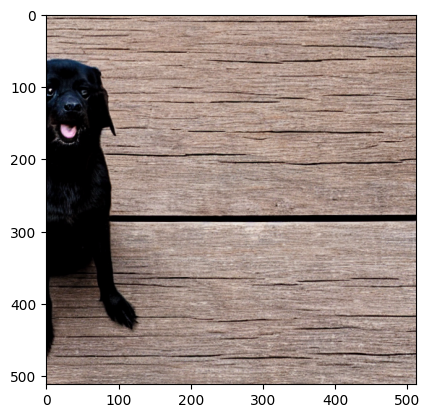

In [15]:
for batch_idx, (data_batch, path_batch) in enumerate(dataloader):
    generator = [torch.Generator(device="cuda").manual_seed(seed.item()) for seed in data_batch["generator_seed"]]
    data_batch["generator"] = generator
    data_batch.pop("generator_seed")
    data_batch["num_inference_steps"] = data_batch["num_inference_steps"][0].item()
    images = pipe(**data_batch).images
    for img, path in zip(images, path_batch):
        print(path)
        print(f"prompt: {data_batch['prompt'][0]}")
        plt.imshow(img)
        break

    break

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [6]:
cls_list = ["n02085936", "n02134084", "n04536866", "n07745940", "n04552348", "n04548280", "n07734744", "n02783161", "n02676566", "n01910747"]

In [7]:
data = pd.concat([pd.read_csv(csv_file, sep=r",(?:(?!\s)+(?!')+(?!$))", engine='python') for csv_file in Path("/mnt/nas65/Dataset/ImageNet1K/ILSVRC/Data/CLS-LOC/train_csv").glob("*.csv")])

OSError: [Errno 93] Protocol not supported: '/mnt/nas65/Dataset/ImageNet1K/ILSVRC/Data/CLS-LOC/train_csv'